# CPU analysis of single-cell ATAC-seq data from 60K cells

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

### Import requirements

In [1]:
%%time
import numpy as np
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
from collections import OrderedDict

import time
import os, wget

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

CPU times: user 2.01 s, sys: 1.18 s, total: 3.19 s
Wall time: 1.46 s


## Set parameters

In [2]:
# filtering peaks
n_top_peaks = 25000 # Number of peaks to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# KNN
n_neighbors = 10 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.4 
umap_spread = 1.0

# Differential peaks
n_diff_peaks = 50 # Number of differential peaks to compute for each cluster

# Marker genes
# Gene coordinates are in GRCh37, from grch37.ensembl.org
markers = ['MS4A1', 'LEF1', 'NKG7', 'TREM1', 'GATA1', 'PAX5']
marker_coords = OrderedDict()
marker_coords['MS4A1'] = ['chr11', 60223225, 60238233, 'fwd']
marker_coords['LEF1'] = ['chr4', 108968701, 109090112, 'rev']
marker_coords['NKG7'] = ['chr19', 51874860, 51875969, 'rev']
marker_coords['TREM1'] = ['chr6', 41235664, 41254457, 'rev']
marker_coords['GATA1'] = ['chrX', 48644962, 48652716, 'fwd']
marker_coords['PAX5'] = ['chr9', 36833272, 37034103, 'rev']

# Number of parallel jobs
sc.settings.n_jobs=32

In [3]:
start_time = time.time()

## Input data

In [4]:
%%time
input_file = "../data/dsci_resting_nonzeropeaks.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/dsci_resting_nonzeropeaks.h5ad',
                  input_file)

adata = anndata.read_h5ad(input_file)
adata_raw = adata.copy()

CPU times: user 1.58 s, sys: 1.52 s, total: 3.09 s
Wall time: 11.3 s


## Preprocessing

In [5]:
preprocessing_start = time.time()

### tf-idf normalization

We use log1p(pseudocount / tf)\*idf, motivated by discussion in [this blog post](http://andrewjohnhill.com/blog/2019/05/06/dimensionality-reduction-for-scatac-data/) as well as our results on various scATAC datasets.

In [6]:
%%time
lognormalized = utils.logtf_idf(adata.X, pseudocount=10**3)
adata.X = lognormalized

CPU times: user 2.21 s, sys: 3.9 s, total: 6.11 s
Wall time: 6.11 s


### Frequency-based peak selection

In [7]:
%%time
adata = utils.filter_peaks(adata, n_top_peaks)
print(adata.X.shape)

(60495, 25000)
CPU times: user 822 ms, sys: 207 ms, total: 1.03 s
Wall time: 1.03 s


In [8]:
print("Preprocessing time: %.2fsec" % (time.time() - preprocessing_start))

Preprocessing time: 7.15sec


## Cluster & Visualize

### PCA

In [9]:
%%time
sc.pp.pca(adata, n_comps = n_components)

CPU times: user 16min 27s, sys: 20min 48s, total: 37min 15s
Wall time: 2min 27s


### UMAP visualization

In [10]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 28.9 s, sys: 8.98 s, total: 37.9 s
Wall time: 14.9 s


In [11]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 1min 24s, sys: 12.1 s, total: 1min 36s
Wall time: 1min 6s


### Graph clustering

In [12]:
%%time
sc.tl.louvain(adata)

CPU times: user 12.2 s, sys: 145 ms, total: 12.3 s
Wall time: 12.2 s


In [13]:
%%time
sc.tl.leiden(adata)

CPU times: user 14.2 s, sys: 158 ms, total: 14.4 s
Wall time: 14.3 s


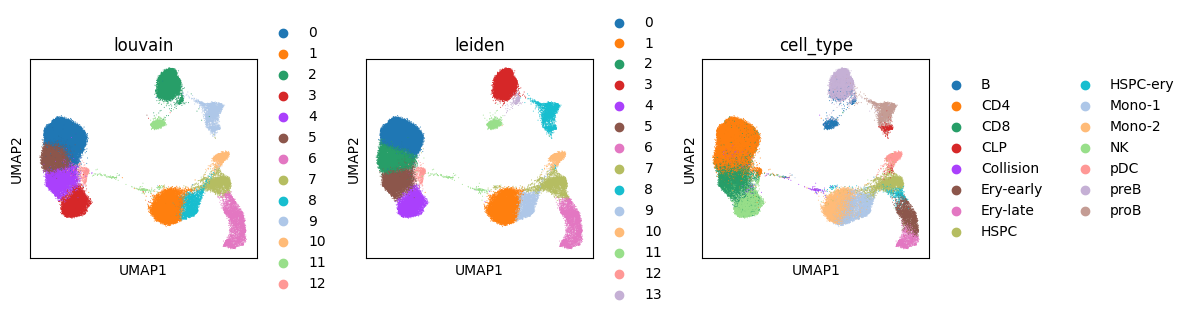

CPU times: user 2.03 s, sys: 134 ms, total: 2.16 s
Wall time: 1.92 s


In [14]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.umap(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.umap(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.umap(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

### tSNE visualization

In [15]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs)

CPU times: user 15min 3s, sys: 897 ms, total: 15min 4s
Wall time: 4min 5s


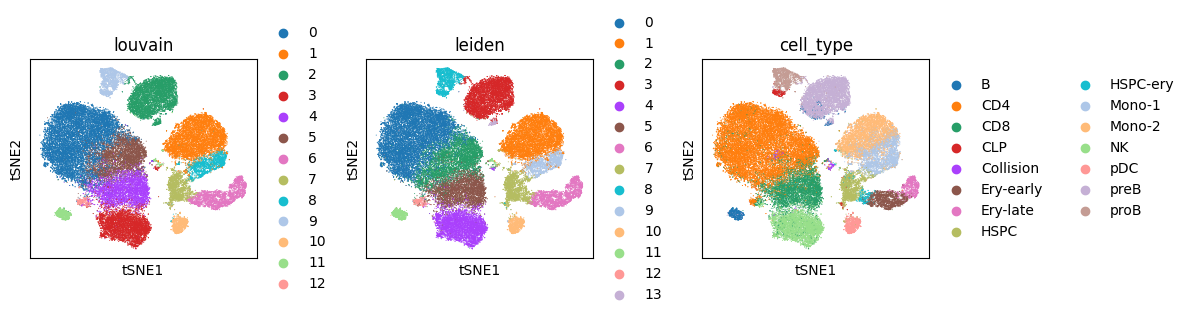

CPU times: user 2.05 s, sys: 118 ms, total: 2.17 s
Wall time: 1.93 s


In [16]:
%%time

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 3), dpi=100)

sc.pl.tsne(adata, color=['louvain'], ax=axs[0], show=False)
sc.pl.tsne(adata, color=['leiden'], ax=axs[1], show=False)
sc.pl.tsne(adata, color=['cell_type'], ax=axs[2], show=False)

plt.tight_layout()
plt.show()

### Visualize marker gene activities

We use the raw adata object to compute gene activity scores. This allows us to consider all peaks, not just the subset we used for clustering and UMAP.

In [17]:
%%time
# find which peaks overlap with each marker gene (+ 5kb upstream)
peaks_per_gene = {gene : [] for gene in markers}

for (i, peak) in enumerate(adata_raw.var_names):
    chrom, coords = peak.strip().split(':')
    start, end = [int(c) for c in coords.split('-')]
    for gene in markers:
        if utils.overlap(marker_coords[gene], [chrom, start, end], 5000, 0):
            peaks_per_gene[gene].append((i, peak))

for gene in peaks_per_gene:
    print(f"{gene} has {len(peaks_per_gene[gene])} nearby peaks")

MS4A1 has 2 nearby peaks
LEF1 has 30 nearby peaks
NKG7 has 4 nearby peaks
TREM1 has 5 nearby peaks
GATA1 has 6 nearby peaks
PAX5 has 30 nearby peaks
CPU times: user 603 ms, sys: 2.6 ms, total: 606 ms
Wall time: 602 ms


In [18]:
%%time
# Calculate per-cell gene activity scores for each marker gene
cell_gene_scores = np.zeros((adata.X.shape[0], len(marker_coords.keys())))
for (i, gene) in enumerate(peaks_per_gene.keys()):
    indices = [x[0] for x in peaks_per_gene[gene]]
    peak_scores = adata_raw.X[:, indices].toarray()
    cell_gene_scores[:, i] = np.sum(peak_scores, axis=1) + 1

# Store per-cell gene activity scores with adata
for (i, gene) in enumerate(markers):
    adata.obs[gene] = np.log2(cell_gene_scores[:, i].tolist())
    adata.obs.loc[np.isneginf(adata.obs[gene]), gene] = 0

CPU times: user 831 ms, sys: 0 ns, total: 831 ms
Wall time: 830 ms


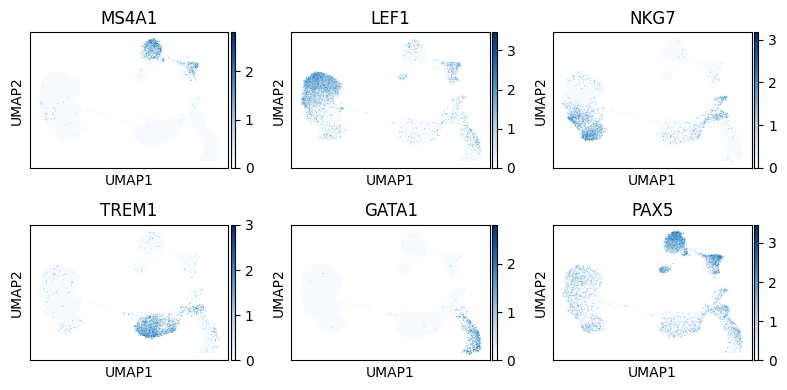

CPU times: user 1.9 s, sys: 162 ms, total: 2.06 s
Wall time: 1.82 s


In [19]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (8, 4), dpi=100)
axs = axs.flatten()
for (i, gene) in enumerate(markers):
    sc.pl.umap(adata, color_map="Blues", color=gene, ax = axs[i], show=False)
plt.tight_layout()
plt.show()

## Find differential peaks

We use a logistic regression model to find peaks that show differential activity across clusters. Here, we needed to increase the maximum number of iterations to 1200 for the model to converge.

In [20]:
%%time
sc.tl.rank_genes_groups(adata, 
                        groupby="louvain", 
                        n_genes=n_diff_peaks, 
                        groups='all', 
                        reference='rest',
                        method='logreg',
                        max_iter=1200
                       )

CPU times: user 38min 19s, sys: 32min 29s, total: 1h 10min 49s
Wall time: 16min 16s


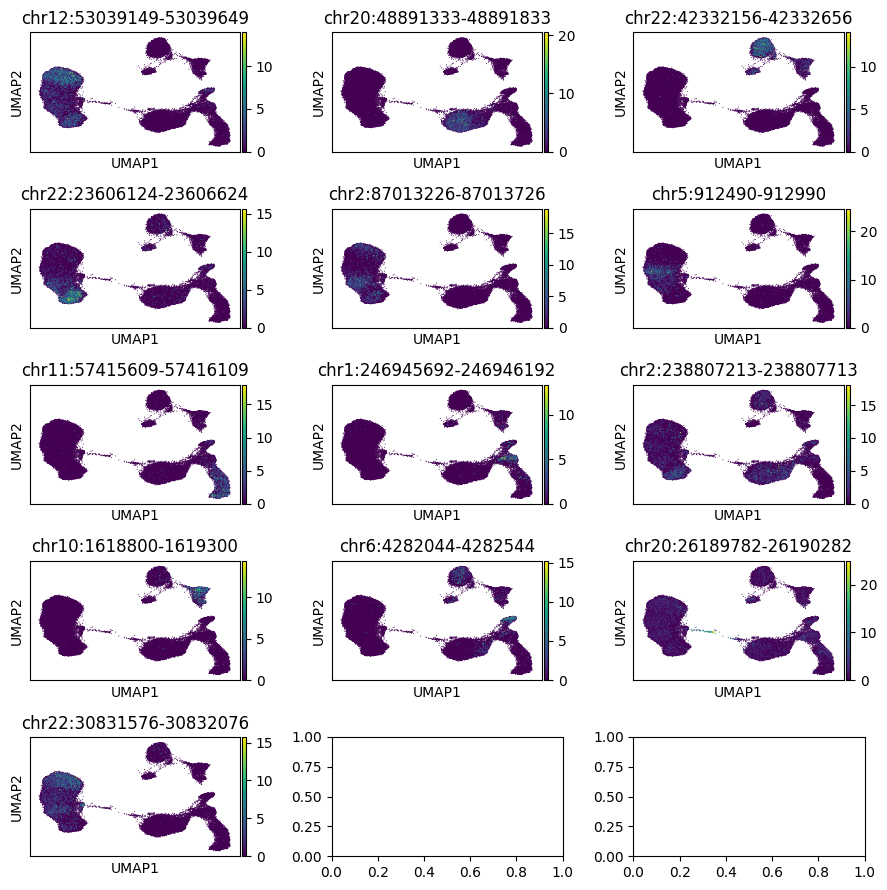

CPU times: user 6 s, sys: 163 ms, total: 6.16 s
Wall time: 5.92 s


In [21]:
%%time

fig, axs = plt.subplots(len(adata.uns['rank_genes_groups']['names'][0])//3 + 1, 3, figsize=(9,9), dpi=100)
axs = axs.flatten()

for (i, peak) in enumerate(adata.uns['rank_genes_groups']['names'][0]):
    sc.pl.umap(adata, color=peak, 
           ax=axs[i], show=False,
           vmax=min(25, np.max(adata[:,peak].X)),
           cmap='viridis'
          )
plt.tight_layout()
plt.show()

In [22]:
print("Full time: %s" % (time.time() - start_time))

Full time: 1508.9890367984772
